Questions on This Model

1. The first thing before anything else is creating a control run. Should that control run have a starting point of sigma_0 0.9? And what should I choose for temperature and salinity?
2. I think I have some confusion on teval. For t_eval, I have tmax*100, which saves only 100 timepoints per year-I think it's not enough? I should save it at least every day? 
3. For the trajectories that go into the rare event algorithm, should they be cut after the transient, or should they start from the beginning run, same question for computing mean, variance, std dev?
4. When calculating the probability of a rare event, (to put in the average return time), I'm using 3 standard deviations above the mean. I guess for AMOC, it should be 3 standard deviations below. Is that calculated from the control run?
5. With autocorrelation function, you stop the analysis as it decays to 0? And for the integral of the AC as well?
6. When you split the run into blocks of time, you use the resampling time/integral autocorrelation time to get the number of blocks you should split it into. This isn't an even number, so if I round down and there's a bit of data left, is it fine to cut it, or should I try to get an even number of blocks?
7. Just to confirm, k is computed based on average return time, and tau/resampling time are approximately equal to the integral autocorrelation time.
8. In order to stop and resample, I have to integrate the rare event algorithm with the code for the Gottwald model. To do that I guess I set tmax to the resampling time, and have the initial variables as inputs. I use values based on analysis of AMOC (time average and resampling time), but when I set the values in the clones i should perturb either salinity or temperature, which one?

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
control = pd.read_csv('control_run.csv')

In [3]:
#drop transient
control_dropped = control.loc[control['t']>=10]
control_dropped.head()

,t,T,S,S0,T0,AMOC
1000,10.000099,0.572942,0.413563,0.5,0.5,0.159379
1001,10.010099,0.574649,0.413486,0.5,0.5,0.161163
1002,10.020099,0.573002,0.413410,0.5,0.5,0.159592
1003,10.030099,0.572261,0.413527,0.5,0.5,0.158733
1004,10.040099,0.570515,0.413849,0.5,0.5,0.156665


Text(0.5, 1.0, 'AMOC Index Over Time at S0 0.5, T0 0.5')

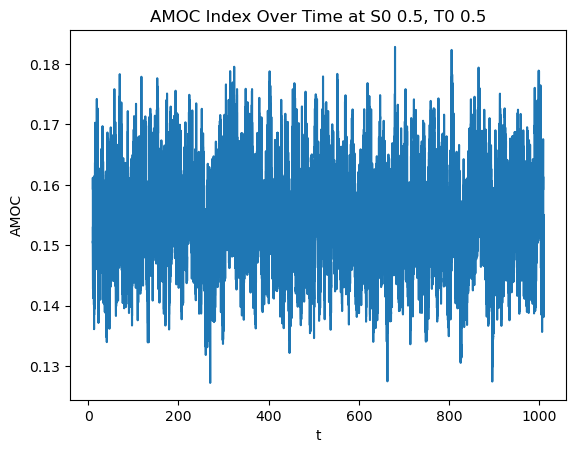

In [4]:
plt.figure()
sns.lineplot(data=control_dropped,x='t',y='AMOC')
plt.title("AMOC Index Over Time at S0 0.5, T0 0.5")

In [5]:
#find mean and standard deviation for Amoc index

#put amoc values in arrays for handling
amoc_list = control_dropped['AMOC'].tolist()
#find mean and standard deviation
control_mean = np.mean(amoc_list)
control_std_dev = np.std(amoc_list)
control_variance = np.var(amoc_list)
print('mean: ',control_mean,'standard deviation: ',control_std_dev,'variance: ',control_variance)

mean:  0.15412271299369934 standard deviation:  0.00713392560826646 variance:  5.089289458427998e-05


(array([   79.,   903.,  6383., 18776., 29212., 26422., 13282.,  4125.,
          764.,    54.]),
 array([0.12719841, 0.13276152, 0.13832464, 0.14388776, 0.14945088,
        0.155014  , 0.16057712, 0.16614024, 0.17170336, 0.17726648,
        0.18282959]),
 <BarContainer object of 10 artists>)

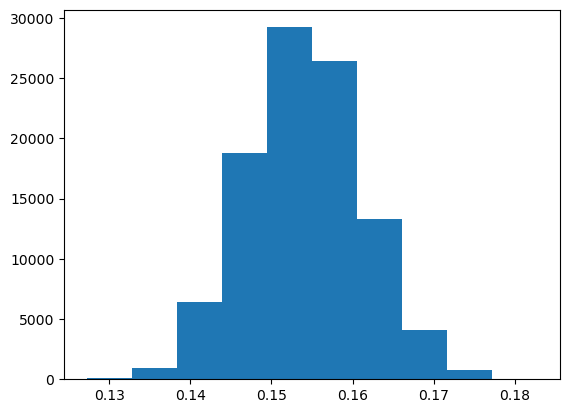

In [6]:
plt.hist(amoc_list)

<AxesSubplot:xlabel='Return times', ylabel='AMOC Index'>

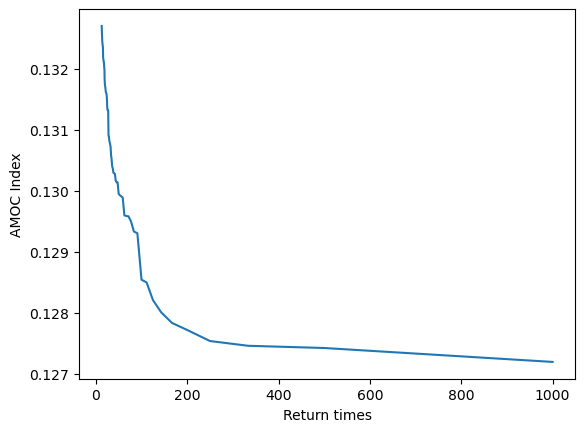

In [9]:
#return time function - calculate return time - probability that x is less than a for each a (need to calculate a)
delta_t=0.01
return_times = []
#decide on a - values below 3 std dev below mean
threshold_a = control_mean - 3*control_std_dev
a_list = []
#construct list of all a 
for val in sorted(amoc_list):
    if val<=threshold_a:
        a_list.append(val)
        
#find probability of x is less than a for all a, find return time
for val in range(1,len(a_list)+1):
    #number of values less is number that val is in the list
    prob_less = val/len(amoc_list)
    return_time = delta_t/prob_less
    return_times.append(return_time)

return_data = pd.DataFrame(data={'Return times':return_times,'AMOC Index':a_list})


sns.lineplot(data=return_data,x='Return times',y='AMOC Index')

In [10]:
'''
Auto-correlation Function:
Split time series into windows (100,000 timepoints/10 so 10 time windows of 10000 timesteps each)
compute AC function as average over all slices:
    - M=10, N=100,000
    - for i in range(M):
        - for t in range (N/M):
            - C[i,t] = y[i,0] * y[i,t] - mu^2
            - ACF = np.mean(C,axis=0)

    then divide by variance
    Take average over all slices
'''
slices = np.array_split(amoc_list, 100)
products = []
slice_length = len(amoc_list) // 100
expectations = np.zeros((100,slice_length))
for slice_num, slice in enumerate(slices):
    for i in range(len(slice)):
        expectations[slice_num,i] = (slice[0]-control_mean)*(slice[i]-control_mean)
    #print(slice[0],slice[i],control_mean**2)
#find mean of AC at each expected value of amoc
ACF_mean = np.mean(expectations, axis=0)
ACF = []

#divide by variance
for mean in ACF_mean:
    R_t = mean/control_variance
    ACF.append(R_t)

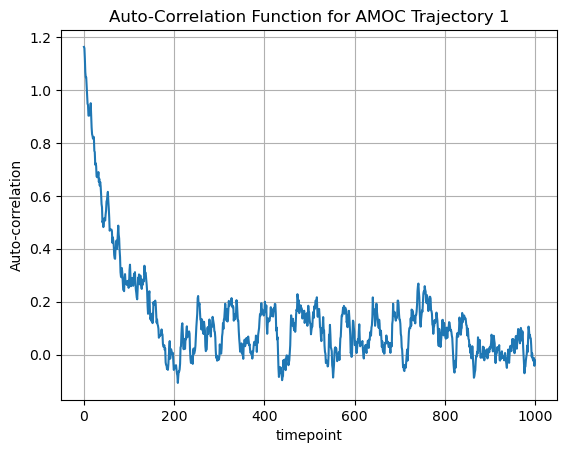

In [11]:
#plot autocorrelation function
plt.figure()
plt.plot(ACF)
plt.title('Auto-Correlation Function for AMOC Trajectory 1')
plt.xlabel('timepoint')
plt.ylabel('Auto-correlation')
plt.grid()

In [13]:
#integral auto-correlation time (system memory), tau
mults=[]
for auto in range(len(ACF)):
    mults.append(ACF[auto]*delta_t)
tau = np.sum(mults)
print(tau)

1.3307260845698317


In [16]:
#compute k
#instead of 3*, do 20*
print(control_variance)
a = control_mean - 20*control_std_dev
print(a)
k=a/(tau*control_variance)
print(k)

5.089289458427998e-05
0.011444200828370138
168.98168952919107
